# <center>RE - Amazon Product Recommendation</center>
### Problem Statement
Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. Build your own recommendation system for products on an e-commerce website like Amazon.com.

**Amazon** currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchases and rated items to similar items, then combines those similar items into a recommendation list for the user.

In this project we are going to build recommendation model for the electronics products of Amazon. 
### Dataset
The source of the dataset  - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/). The repository has several datasets. For this case study, we are using the Electronics dataset. The columns in this dataset are:
- **userId**
- **productId**
- **ratings**
- **timestamp**

---
### Imports and Configurations

In [1]:
# Utilities
import math, random, warnings
from time import time
from datetime import datetime
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

# Mathematical calculation
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-surprise recommender package
from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly

In [2]:
# Configure for any default setting of any library
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
# sns.set(style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Comments**
- **InteractiveShell** setting displays the full output for a cell, not just the latest one.
- Ignore all warnings in the notebook for an user friendly view
- **%matplotlib inline** sets the backend of matplotlib to the 'inline' backend: With this backend, the output of plotting commands is displayed inline without needing to call plt.show() every time a data is plotted.
- **sns.set()** sets few of the Seaborn's asthetic parameters
- Pandas **display.float_format** supress the scintific notation in pandas dataframe for easy readbability

---
## Q1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics)
### Load the Dataset

In [3]:
# Load the dataset into a Pandas dataframe called ratingsand skip any lines that return an error
ratings = pd.read_csv('ratings_Electronics.csv', 
                      names=['userId', 'productId', 'rating', 'timestamp'], 
                      error_bad_lines=False, 
                      warn_bad_lines=False)

# Save an original copy of the dataframe
ratings_original = ratings.copy(deep=True)

In [4]:
# Check the head of the dataset
ratings.head()
# Check the tail of the dataset
ratings.tail()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.000,1334707200


,userId,productId,rating,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.000,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.000,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.000,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.000,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.000,1312675200


**Comments**
- To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

### Inspect the Dataset

In [5]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 7824482
Number of columns : 4


In [6]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
# Check for any Null values in the dataset
ratings.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

**Observations**
- The dataset comprises of **7824482 rows** and **4 columns**.
- There are **NO null/missing** present in the dataset.
- int64 datatype of timestamp column indicates that it is in **Unix timestamp** format where each number is the number of seconds passed after **January 1, 1970 at UTC**.

#### Drop Duplicates
It's not certain how this data was collected or if it processed before it was published; there could be some duplicated ratings in here. To check, we'll see if there are any duplicated userId and productId combination.

In [8]:
# Get a dataframe consisting only of ratings that are duplicated
rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

# ratings.drop_duplicates(subset=['userId','productId','rating'],inplace=True)

,userId,productId,rating,timestamp


There are **NO Duplicate** rows present.
#### Readable Timestamp
As observed, the timestamp is in Unix timestamp format where each number is the number of seconds passed after January 1, 1970 at UTC. Convert the timestamp column to a readable date time format and change the datatype to datetime.

In [9]:
# Convert the timestamp column to a readable date time format
ratings['timestamp'] = ratings.timestamp.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
# Convert the datatype to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.head()
ratings.info()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.000,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.000,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.000,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.000,2012-04-18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 238.8+ MB


In [10]:
# Get the timespan of data
print("Minimum recorded ts:",ratings.timestamp.min())
print("Maximum recorded ts:",ratings.timestamp.max())

Minimum recorded ts: 1998-12-04 00:00:00
Maximum recorded ts: 2014-07-23 00:00:00


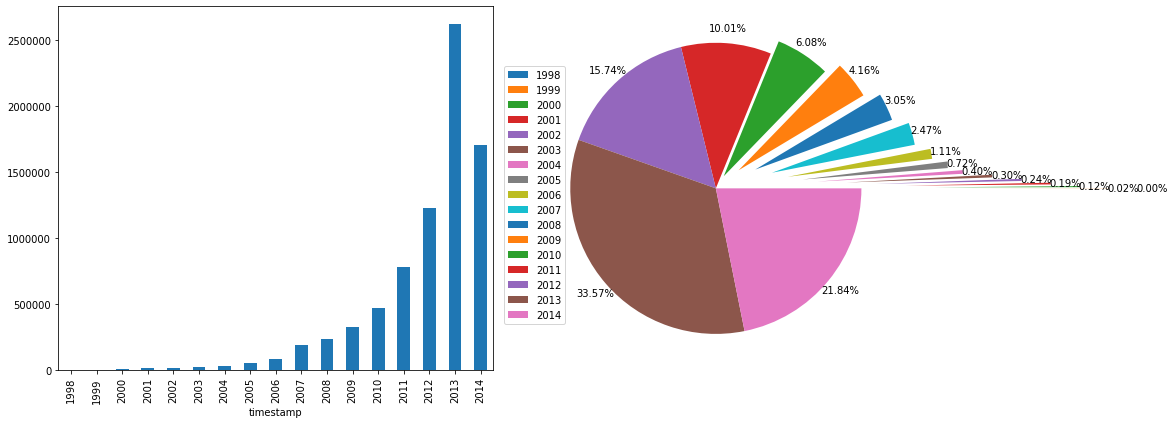

In [11]:
# Visualize the year wise ratings distribution
fig, ax = plt.subplots(1, 2, figsize=(16,6))
year_wise_count = ratings.timestamp.groupby(ratings['timestamp'].dt.year).count()
_ = year_wise_count.plot(kind='bar', ax=ax[0])
explode = (1.9,1.7,1.5,1.3,1.1,0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0,0,0)
_ = ax[1].pie(year_wise_count, explode=explode, autopct='%1.2f%%', pctdistance=1.1)
_ = ax[1].legend(labels=year_wise_count.index,bbox_to_anchor=(0.1,0.85))
plt.tight_layout()

**Observaton**:
- The data is collected from 1998 till 2014. And we can see every year the ratings for electronics products are increasing continuously except for an unusual hike in the year 2013 for some unknown reasons.
- After converting to readable format of datatime, it is noticed that this column doesn't contain any time component, just the date component is there.

As there is no time (HHMMSS) component present, it is **not feasible** to somehow make a concept of transaction out of it. Provided the exact hour minute and seconds components are given for each record, grouping them into simillar timestamps and userIds, we could've considered some products to be purchased in a single transaction. Besided this is a product review dataset. Hence we can't apply **Market Basket** analysis. So dropping the timestamp column, which is of no use now.

In [12]:
# Drop the timestamp column
ratings.drop(labels='timestamp', axis=1, inplace=True)
ratings.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.000
1,A2CX7LUOHB2NDG,0321732944,5.000
2,A2NWSAGRHCP8N5,0439886341,1.000
3,A2WNBOD3WNDNKT,0439886341,3.000
4,A1GI0U4ZRJA8WN,0439886341,1.000


In [13]:
# Check the count of unique user and product data
unique_original = (ratings.userId.nunique(), ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 4201696
Count of unique Products : 476002


In [14]:
# Find the minimum and maximum ratings
print("The Minimum rating is:",ratings.rating.min())
print("The Maximum rating is:",ratings.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each ratings:


5.000    4347541
4.000    1485781
1.000     901765
3.000     633073
2.000     456322
Name: rating, dtype: int64

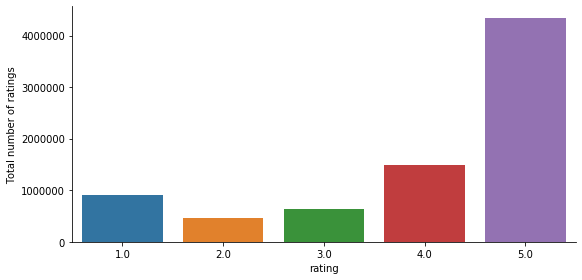

In [15]:
# Check the distribution of ratings 
print('Count of observations in each ratings:')
ratings.rating.value_counts()
g = sns.factorplot("rating", data=ratings, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

In [16]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    176283
2.000    123419
3.000    152827
4.000    223845
5.000    358458
Name: productId, dtype: int64

**Observations:**
- Extreme high count in rating 5 indicates Amazon delivers good quality products in electronics department.
- Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
- This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
- Users do not bother to rate usually for the average experience with any product, so is the reason rating 2 and 3 are having lesser frequency compared to others.

---
## Q2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)
### Data Sparsity
Many recommender systems run into a problem called the **Cold-Start problem**. Essentially, a user can't be recommended anything because they haven't rated anything! Additionally, if you introduce a new product, nobody has rated it and it can't be recommended. Since we have rating data, we're going to run into either of these problems. Because of this problem, also the mathematical space becomes very much sparse.

If a user has rated one or very few items, how well could a recommender system work? If we have one point of a line, we have no idea which direction the line is going. In the same vein, if we have a user with only one or very few ratings, though we might be able to rule out some items, but it would be very difficult to be confident in our recommendations for that user.

For this reason, I'm going to explore how many ratings have been submitted per user.

In [17]:
# Find the top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='# ratings')
# most_rated = ratings.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

,UserId,# ratings
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


### Density of the matrix
Density of a matrix can be described as the measure of closeness of datapoints to each other when the matrix is projected into a mathematical space with the no of dimensions equal to the column of the matrix and each row representing a point in that dimensional space. More the density of the matrix more close the data points are in the mathematical space forming a cloud or any other shape. When the data points are scattered far apart in the vector space, such matrix is called as a sparse matrix.

In [18]:
# Find the density of the rating matrix
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = ratings.userId.nunique() * ratings.productId.nunique()
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.5f}%'.format(density))

Total observed ratings in the dataset  : 7824482
Total ratings possible for the dataset : 2000015699392
Density of the dataset                 : 0.00039%


**Getting rid of users who have rated less than 50 products**, as we can see the **density of the user-item matrix is 0.00039%**

In [19]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['# ratings'] >= 50].UserId)]
print('# unique USERS who have rated 50 or more products :', ratings.userId.nunique())
print('# unique USERS dropped      :', unique_original[0] - ratings.userId.nunique())
print('# unique ITEMS remaining    :', ratings.productId.nunique())
print('# unique ITEMS dropped      :', unique_original[1] - ratings.productId.nunique())
print('\nFinal length of the dataset :', len(ratings))

# unique USERS who have rated 50 or more products : 1540
# unique USERS dropped      : 4200156
# unique ITEMS remaining    : 48190
# unique ITEMS dropped      : 427812

Final length of the dataset : 125871


**Observations:**
- There was a huge no of users (4200156) who haven't rated atleast 50 products. These records would not have drawn a proper intuation about user similarity considering the total no. of records in the dataset. Hence we dropped all such users and are now left with **1540 unique users** with 50 or more ratings under each one's umbrella. Which is almost **0.04%** of total no of users in the original dataset.
- In the process of getting rid of such users, we ended up dropping 427812 unique products and their ratings. Now we are left with only **48190 unique products** which is almost **10%** of the original list of products.
- As a whole we **dropped** 7824482-125871=**7698611 records** which is almost **98.4%** of the original dataset.

In [20]:
# Find the density of the final matrix
final_ratings_matrix = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of final_ratings_matrix          :', final_ratings_matrix.shape)
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

Shape of final_ratings_matrix          : (1540, 48190)
Total observed ratings in the dataset  : 125871
Total ratings possible for the dataset : 74212600
Density of the dataset                 : 0.17%


In [21]:
# Calculate the increase in density
print('The density of the user-item matrix increased by {:4.2f}%'.format((0.17-0.00039)/0.00039))

The density of the user-item matrix increased by 434.90%


**Observations:**
- After dropping about 98.4% of the data with very less ratings per user, the **density of the resultant matrix increased by 434.9%**.
- A **density of 0.17%** shows that the data set is still highly sparse such that it is not feasible to visualize with matplotlib spy.

---
## Q3. Split the data randomly into train and test dataset. (For example split it in 70:30 ratio)

In [22]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=5)
trainset.head()
testset.head()

,userId,productId,rating
5815696,A197T2N6RU7K56,B007N6OED8,5.000
412740,A3HR0ZZOFKQ97N,B0001Y7UAI,5.000
444340,AGHZXQL9F94T9,B0002A6YVC,2.000
3481712,A2XJMQ2COPGWJH,B003NSBF32,2.000
4580022,A2D1LPEUCTNT8X,B004YKKT26,4.000


,userId,productId,rating
4930282,A2UOHALGF2X77Q,B005G81E9M,3.000
3333831,A27M75LRSJ788H,B003FG6IV6,5.000
7490425,A35W3JQYP0M655,B00E3FHXYO,5.000
679608,A1FR68QH6Z4YZM,B0009R3N9E,5.000
583942,A25FL6VLD7S23S,B00079Q5DK,2.000


In [23]:
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


Text(0.5, 1.0, 'Training Set')

Text(0.5, 1.0, 'Testing Set')

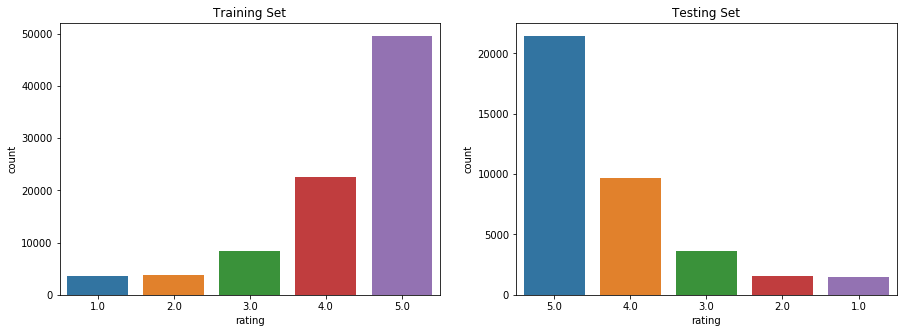

In [24]:
# Check the ratings distribution in both train and test set
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Training Set')
sns.countplot('rating', data=trainset, ax=axes[0])
axes[1].set_title('Testing Set')
sns.countplot('rating', data=testset, ax=axes[1], 
              order=testset.rating.value_counts().index)

**Observations**:
- Train Test set split resulted into 88109 training data and 37762 testing dataset.
- Both the datasets are having almost equal no of data points under each rating.

---
## Q4. Build Popularity Recommender model. (Non-personalised)
### Popularity Based
Easiest way to build a recommendation system is popularity based, simply over all the products that are popular, So how to identify popular products, which could be identified by which are all the products that are bought most.

Let's group the products to find the count of reatings each one of them has recieved. this could be considered as their individual scores.

In [25]:
# Create a method to recommend products based on popularity
def recommend_popular(df, top_n, userId=None):
    # Generate a recommendation rank based upon score 
    df['Rank'] = df['score'].rank(ascending=0, method='first') 
    recommendations = df.sort_values(['score', 'productId'], ascending=[0,1])
    
    # Add UserId column for which the recommendations are being generated 
    if userId:
        recommendations.insert(0,'userId',userId)
    
    # Get the top N recommendations 
    return recommendations.head(top_n)

**Method 1**: UserId count for each unique product as recommended score<br/>
The score for each product in this method is calculated as the sum of the number of users rated. Ratings can be of good and bad. This method doesn't bother about the quality of the ratings recieved, rather just counts how many ratings are present for each product.

In [26]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'userId': 'count'}).reset_index()
product_grp.rename(columns={'userId': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [27]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
39003,B0088CJT4U,206,1.000
24827,B003ES5ZUU,184,2.000
11078,B000N99BBC,167,3.000
38250,B007WTAJTO,164,4.000
38615,B00829TIEK,149,5.000


---
**Method 2**: Average of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the average of the ratings recieved. This method is better than method 1.

In [28]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'mean'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,2.500
3,0972683275,4.750
4,1400501466,3.333


In [29]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
0,0594451647,5.000,1.000
5,1400501520,5.000,2.000
12,1400699169,5.000,3.000
13,1685560148,5.000,4.000
14,3744295508,5.000,5.000


---
**Method 3**: Sum of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the sum of all ratings recieved. This is practically the best approach to determine the popularity of an item considering only the users ratings are given. This is also preferred over avg (method 2) as average of one 5 star rating is exactly same as the average of more than one 5 star ratings, but the product with more 5 star ratings would be considered as the most popular.

In [30]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'sum'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,5.000
3,0972683275,19.000
4,1400501466,20.000


In [31]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
24827,B003ES5ZUU,895.000,1.000
39003,B0088CJT4U,869.000,2.000
11078,B000N99BBC,797.000,3.000
38250,B007WTAJTO,771.000,4.000
38615,B00829TIEK,661.000,5.000


In [32]:
# Find recommendation for couple of users
find_recom = {'A197T2N6RU7K56': 6, 
              'A1FR68QH6Z4YZM': 3, 
              'A10AFVU66A79Y1': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_popular(product_grp,find_recom[user],user)
    print("\n") 

Top 6 recommendations for the userId: A197T2N6RU7K56


,userId,productId,score,Rank
24827,A197T2N6RU7K56,B003ES5ZUU,895.000,1.000
39003,A197T2N6RU7K56,B0088CJT4U,869.000,2.000
11078,A197T2N6RU7K56,B000N99BBC,797.000,3.000
38250,A197T2N6RU7K56,B007WTAJTO,771.000,4.000
38615,A197T2N6RU7K56,B00829TIEK,661.000,5.000
38611,A197T2N6RU7K56,B00829THK0,605.000,6.000




Top 3 recommendations for the userId: A1FR68QH6Z4YZM


,userId,productId,score,Rank
24827,A1FR68QH6Z4YZM,B003ES5ZUU,895.000,1.000
39003,A1FR68QH6Z4YZM,B0088CJT4U,869.000,2.000
11078,A1FR68QH6Z4YZM,B000N99BBC,797.000,3.000




Top 8 recommendations for the userId: A10AFVU66A79Y1


,userId,productId,score,Rank
24827,A10AFVU66A79Y1,B003ES5ZUU,895.000,1.000
39003,A10AFVU66A79Y1,B0088CJT4U,869.000,2.000
11078,A10AFVU66A79Y1,B000N99BBC,797.000,3.000
38250,A10AFVU66A79Y1,B007WTAJTO,771.000,4.000
38615,A10AFVU66A79Y1,B00829TIEK,661.000,5.000
38611,A10AFVU66A79Y1,B00829THK0,605.000,6.000
39338,A10AFVU66A79Y1,B008DWCRQW,561.000,7.000
28761,A10AFVU66A79Y1,B004CLYEDC,551.000,8.000


**Observations:**
- Popularity recommender models works based on the popularity of products.
- The products with highest number of ratings gets recommended irrespective of user's interest. This is the model used as a basic recommendation even when the user is not even logged into Amazon.
- So is observed above that all the 3 users recieved the same recommendations i.e the top n rated products under Electronics category.

---
## Q5. Build Collaborative Filtering model
### Collaborative Filtering
Collaborative filtering is the process of filtering out information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources, etc.This is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a matter, A is more likely to have B's opinion on a different matter than that of a randomly chosen person.

This technique doesn’t need anything else except users’ historical preference on a set of items. Because it’s based on historical data. In terms of user preference, it usually expressed by two categories. 
- **Explicit Rating**: It is a rate given by a user to an item on a sliding scale, like 5 stars for any movie or an item. This is the most direct feedback from users to show how much they like an item. 
- **Implicit Rating**: This suggests users' preference indirectly, such as page views, clicks, purchase records, whether or not listen to a music track, and so on.

**Nearest Neighborhood** - The standard method of Collaborative Filtering is known as Nearest Neighborhood algorithm. 

**Types of Collaborative Filtering (CF)**
- Item Based Collaborative Filtering (IBCF)
  - Compute similarity between Items
- User Based Collaborative Filtering (UBCF)
  - Compute similarity between Users
  
**IBCF vs. UBCF**
- IBCF is more efficient than UBCF
- Typical applications involve far more Users than Items. Hence Similarity matrix for IBCF is more compact than UBCF
- Similarity estimates between items is also more likely to converge over time than similarity between users. Hence the similarities can be pre computed and cached unlike similarity between users that need to be dynamically computed at every certain interval.
- However, the IBCF recommendations tend to be more conservative than UBCF

**Similarity Metrics**: The following are the two popular similarity metrics used in recommender systems. **Jaccard Similarity** is useful when the User/Item Matrix contain binary values<br/>
- **Cosine Similarity**: Similarity is the cosine of the angle between the 2 item vectors represented by:
$$Cosine\;Similarity:CosSim(x,y)=\frac{\sum_i{x_iy_i}}{\sqrt{\sum{(x_i)^2}}\sqrt{\sum{(y_i)^2}}}=\frac{\langle x, y \rangle}{\|x\|\|y\|}$$

- **Pearson Correlation**: Similarity is the Pearson correlation between two vectors represented by:
$$Pearson\;Correlation:Corr(x, y)=\frac{\sum_i{(x_i-\bar{x})(y_i-\bar{y})}}{\sqrt{\sum{(x_i-\bar{x})^2}}\sqrt{\sum{(y_i-\bar{y})^2}}}=\frac{\langle x-\bar{x}, y-\bar{y} \rangle}{\|x-\bar{x}\|\|y-\bar{y}\|}=CosSim(x-\bar{x},\;y-\bar{y})$$

### User Based Collaborative Filtering (UBCF)
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.
$$\widehat{r}_{ui}=\frac{\sum_{v\in{N_i^k(u)}}{similarity(u,v).r_{vi}}}{\sum_{v\in{N_i^k(u)}}{similarity(u,v)}}$$
### Item Based Collaborative Filtering (IBCF)
This algorithm first finds the similarity score between items. Based on this similarity score, it then picks out the most similar items and recommends that to the user which these similar items have been liked or bought previously.
$$\widehat{r}_{ui}=\frac{\sum_{j\in{N_u^k(i)}}{similarity(i,j).r_{uj}}}{\sum_{j\in{N_u^k(j)}}{similarity(i,j)}}$$

First step is to create the sparse matrix. Let's attempt both UBCF and IBCF consecutively.

In [33]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A100WO06OQR8BQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A105S56ODHGJEK,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A105TOJ6LTVMBG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A10AFVU66A79Y1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [34]:
# Create the Item-User sparse matrix
item_user = ratings.pivot(index='productId', columns='userId', values='rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (48190, 1540)


userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0594481813,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0970407998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0972683275,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400501466,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now, we will calculate the similarity. We can use the cosine_similarity function from sklearn to calculate the cosine similarity.

In [35]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000,0.011,0.000,0.015,0.026,0.000,0.024,0.034,0.012,0.020,...,0.025,0.000,0.000,0.025,0.036,0.000,0.000,0.038,0.016,0.014
A100WO06OQR8BQ,0.011,0.000,0.013,0.016,0.009,0.010,0.013,0.020,0.017,0.002,...,0.015,0.003,0.012,0.000,0.021,0.018,0.000,0.017,0.000,0.003
A105S56ODHGJEK,0.000,0.013,0.000,0.000,0.022,0.065,0.000,0.000,0.032,0.000,...,0.000,0.000,0.028,0.000,0.011,0.000,0.000,0.004,0.023,0.000
A105TOJ6LTVMBG,0.015,0.016,0.000,0.000,0.000,0.000,0.017,0.003,0.000,0.000,...,0.036,0.000,0.011,0.000,0.016,0.020,0.000,0.040,0.000,0.000
A10AFVU66A79Y1,0.026,0.009,0.022,0.000,0.000,0.021,0.000,0.000,0.000,0.015,...,0.000,0.000,0.015,0.036,0.050,0.000,0.000,0.000,0.000,0.000


In [36]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)
item_similarity_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0594481813,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0970407998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
0972683275,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400501466,0.000,0.000,0.000,0.000,0.000,0.539,0.421,0.000,0.000,0.523,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now that we have both the smiliarity matrices in our hand, let's see the n-Neighborhood.

In [37]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [38]:
# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
A100UD67AHFODS,A2FZQF0MH29VYN,A11FX8HL2ANK6T,A3CG93783LP0FO,A2NOW4U7W3F7RI,A2LB4FLRZG6CUV,A2DG63DN704LOI,AT53ZTTO707MB,A2XX2A4OJCDNLZ,A33XMCG1UFDSY2,A2YW6XOID7GV6G
A100WO06OQR8BQ,A3963R7EPE3A7E,A30UP2KKD5IQEP,A2Y3WWPUKIJ59I,A298GL2D0BHGKZ,A1CST2WUA32GP0,A15XI2BEGGFEOW,A3D822N1K2IAQD,A2L4ZGN7GZJ95T,A18S2VGUH9SCV5,AXP8GO5Q3AXSA
A105S56ODHGJEK,A17UNMURMLX0ZE,ABMNX856X89CS,ANTN61S4L7WG9,A2LF16F0KX9L7P,A2UKE7GIVC7XFW,AJX9A4Q19UTJU,A2R1HUYHXV7H18,A3J3ZHGDUDPCFL,A1WXG10FJ353K0,A20L63B48RPSOH
A105TOJ6LTVMBG,A1TQBAHI3M4ZBQ,A10ZFE6YE0UHW8,A2XXBZPQT5EXHV,A1NZLRAZJGD99W,A1D27BCSYV7VWH,AVTJEWTCJ3PBE,AAK6SOEJY30YG,A2GKMXRLI7KLFP,A2VCXIAWCPQ13P,AKSFZ4G1AXYFC
A10AFVU66A79Y1,ACQYIC13JXAOI,A25QJBK33C4O0R,A2PMR2PIGWKCQ9,A4H4KYSM2KQ85,A2TVH2OBNXYXHV,A84FLVDK2R5JF,A2UOHALGF2X77Q,A24RCBRDXRXR0Y,A2IFKH3TJ10387,A3JLOIXFM75QNV
A10H24TDLK2VDP,ANTN61S4L7WG9,A2QRXQPHDMFCQV,A3V2EZ6MA32FF6,A3SP7T2PZ3HSDE,AO09RWV40IX78,A3J3ZHGDUDPCFL,A3QNQQKJTL76H0,A1RL1OTV8IJMVD,A19W47CXJJP1MI,A3LDLV1GWQJLEQ
A10NMELR4KX0J6,ARC5ASW9CUAGP,A1PS4OYWUB0VX,A3F7USIDJBR8WU,A3GX0FAMEXV6FB,A32HSNCNPRUMTR,A1L5TA5UQF7EWE,A3223W5IROMYTY,A1ZPUEHF4AES86,A17W0GMB0YY83M,A2HV76MYH7UL3S
A10O7THJ2O20AG,AWSK1ZAEU1KFL,A365PBEOWM7EI7,AZ8XSDMIX04VJ,AN9CP6J4JF91X,AJEOFP6ZWY0MK,A2HRHF83I3NDGT,A24P4E3RJ6AX94,A28621TSIR5EOG,A1VLE2SH9J8WYS,A2A4X545ERLS7H
A10PEXB6XAQ5XF,A267FU71Z01CIH,A1TR1R2QKWRSRA,A2MJ8OL2FYN7CW,A1CMD08Z49PGKQ,A2BLFCOPSMBOZ9,A2CWIYIETNBAK3,A1MCH5RXDOH87H,A28X0LT2100RL1,A1PI8VBCXXSGC7,AJX9A4Q19UTJU


In [39]:
# Find 10 neighbors of each item
item_10_neighbors = find_n_neighbors(item_similarity_df, 10)
item_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
productId,,,,,,,,,,
0594451647,B005B47AIU,B005OIB714,B0076AUCKU,B0058FN6V2,B0073V1NP0,B000MYOJMY,B00AV1UWWY,B005J8OBJE,B004EHSP3Y,B008UMF3T8
0594481813,B00D30UX8I,B0009YFS4A,B00BSE79KQ,B00C80UFJQ,B00CBDUD60,B009WESJEY,B007C2IKQU,B007NNTLK2,B001QSD5GQ,B007XACV8O
0970407998,B00009R8D3,B00078Y24K,B001E9BIU2,B001EYU6Q4,B0015IOUK2,B000XALL8W,B001ADUCTU,B005JY5XK4,B001CT00AS,B001CT00BW
0972683275,B007J4BOWI,B008U25LI6,B003ICXCZM,B004HW67MW,B003GZDB1Q,B0002ZPIXM,B001TLEXES,B00681RUR6,B00009UH9J,B008LCVREM
1400501466,B0049QV65O,B00BC4J5O0,B0098JS19G,B002LITT3S,B000GT6HAM,B000J46TFW,B002WV6LA8,B00462RU60,B004P1ITV2,B00094OWKQ
1400501520,B0030LKGAU,B0053EVW1Y,B004HO58NO,B002YIG8BQ,B004P1ITV2,B00462RU60,B004P1ITU8,B000GT6HAM,B00009W3U9,B0053EVVTW
1400501776,B00462RU60,B003D2BS4E,B0053EVVTW,B004P1ITV2,B004P1ITU8,B002YIG8BQ,B005KHFF2Q,B000FSILBM,B000GT6HAM,B008I6672I
1400532620,B00BGTN06A,B006K59QRC,B002NFZSL6,B007AHQMTO,B00004WHFL,B00BJ91VEA,B0010KWCWI,B00AEFFLJQ,B00GQTDOC0,B00ASQJTY4
1400532655,B005JHF5RM,B004NTO2I0,B0034XDTF8,B000E39V9E,B0003009E4,B002V92X9Y,B000MNA082,B007STXHTM,B001S0RTXM,B007COEPO4


Let's verify the similarity in both item and user base to find out if our calculatios are correct

In [40]:
def get_users_similar_products(user1, user2):
    common_products = ratings[ratings.userId == user1].merge(
    ratings[ratings.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [41]:
# Check the similarity of two users
get_users_similar_products('A100UD67AHFODS', 'A2FZQF0MH29VYN')

,rating_x,rating_y,productId
0,5.000,5.000,B0002KVQBA
1,3.000,4.000,B002HWRJY4
2,4.000,5.000,B0071BTJPI
3,5.000,5.000,B0097BEFYA
4,5.000,5.000,B00A83I8G2


**Observations**:
- From the above step we can see that the similarity we generated is true since both the given users (**A100UD67AHFODS**, **A2FZQF0MH29VYN**) have almost same ratings and likings.

item_similarity and user_similarity are item-item and user-user similarity matrix in an array form respectively. The next step is to make predictions based on these similarities. Let’s define a function to do just that.

In [42]:
# Method to predict the rating
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Finally, we will make predictions based on user similarity and item similarity and recommend product based on similarity.

In [43]:
# Predict the ratings for both UBCF and IBCF
st=time()
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

item_prediction = predict(user_item, item_similarity, type='item')
# Commenting out following 2 lines as it throws MemoryError due to the high sparsity
# item_prediction = pd.DataFrame(item_prediction, index=item_user.index, columns=item_user.columns)
# item_prediction.head()
print('Time taken %.2fs to find out the user and item prediction' % (time()-st))

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.017,0.002,0.006,0.012,0.014,0.006,0.010,0.002,0.032,0.006,...,0.002,0.015,0.009,0.018,0.013,0.021,0.002,0.038,0.025,0.002
A100WO06OQR8BQ,0.006,0.002,0.004,0.021,0.009,0.006,0.019,0.002,0.011,0.005,...,0.002,0.019,0.002,0.009,0.005,0.002,0.009,0.014,0.006,0.004
A105S56ODHGJEK,-0.003,-0.003,-0.001,0.003,0.003,-0.003,-0.001,-0.000,0.003,-0.002,...,-0.003,0.006,-0.003,0.000,0.005,-0.003,-0.003,0.020,-0.003,0.001
A105TOJ6LTVMBG,-0.002,0.002,0.001,0.015,0.006,-0.002,-0.002,-0.002,0.011,-0.002,...,-0.002,-0.002,-0.002,-0.002,0.001,0.008,-0.002,0.010,0.003,-0.002
A10AFVU66A79Y1,-0.003,-0.003,0.005,0.010,0.010,0.003,0.006,-0.002,0.004,0.004,...,-0.003,0.012,0.004,0.000,-0.001,-0.003,-0.003,0.013,0.004,-0.003


Time taken 1203.40s to find out the user and item prediction


In [44]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommedations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommedations.index.name = 'Recommended Items'
    recommedations.columns = ['user_ratings', 'user_predictions']
    
    # Take the products which user has NOT rated
    recommedations = recommedations.loc[recommedations.user_ratings == 0] 
    recommedations = recommedations.sort_values('user_predictions', ascending=False)
    return recommedations.head(top_n)

In [45]:
# Find recommendation for couple of users using UBCF
find_recom = {'A100UD67AHFODS': 6, 
              'A100WO06OQR8BQ': 3, 
              'A105S56ODHGJEK': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])
    print("\n") 

Top 6 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.000,0.873
B007WTAJTO,0.000,0.684
B0088CJT4U,0.000,0.509
B00G4UQ6U8,0.000,0.485
B002V88HFE,0.000,0.463
B00829THK0,0.000,0.462




Top 3 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.000,0.883
B00829TIEK,0.000,0.749
B004CLYEDC,0.000,0.730




Top 8 recommendations for the userId: A105S56ODHGJEK


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.000,1.343
B00829THK0,0.000,0.885
B002R5AM7C,0.000,0.844
B004CLYEDC,0.000,0.836
B004CLYEFK,0.000,0.792
B004T9RR6I,0.000,0.662
B003ES5ZUU,0.000,0.616
B00834SJNA,0.000,0.607


**Observations**:
- Unlike popularity model, the recommendations are personalized here as indicated by the different set of recommendations for different users based on their likings.
- It is taking too long to calculate the item-item similarity as the item base is pretty huge than the user base.

---
UBCF and IBCF are **Neighborhood approaches** of collaborative recommendation system. Based on certain similarity metrics, the nearest neighbors are calculated which are considered to be similar in terms of past history. Because of the high sparsity of the user-item matrix, it is computationally heavy to calculate the neighborhood for the user-user or item-item similarity resulting in non-reliable recommendations some time. To deal with this problem of huge sparsity, **Latent Factor approach** is used.
### Matrix Factorization based Collaborative Filtering
Matrix Factorization based CF works on the principle of **Latent Factor approach**. It deals with the latent factors of item base resulting in reducing the dimensionality of the mathematical space in one hand, and improving the performance because of the less sparsity of the resultant user-item base on the other.
### Singular Value Decomposition (SVD)
Singular Value Decomposition (SVD) can be used to decompose any given Matrix, M into a product of 3 matrices as follows:
$$M=U\times\sum\times{}V^T$$
Where:
- $U$: Left Singular Matrix
- $V$: Right Singular Matrix
- $\sum$: Diagonal Matrix of Latent Factors, and the values of the diagonal of $\sum$ are called the **singular values**

The matrix can be approximated to a lower rank by considering only the largest singular values.

In [46]:
# Trying out different latent factors
svd_list = [svds(user_item, k=k) for k in [100,250,500,750,1000]]
pred_list = [pd.DataFrame(np.dot(np.dot(svd[0], np.diag(svd[1])), svd[2]), 
                          index=user_item.index, 
                          columns=user_item.columns) for svd in svd_list]
RMSE_list = [round((((user_item.mean() - pred.mean()) ** 2).mean() ** 0.5), 5) for pred in pred_list]
RMSE_list

[0.00236, 0.00181, 0.00133, 0.00096, 0.0007]

In [47]:
# Singular Value Decomposition
U, sigma, Vt = svds(user_item, k=50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [48]:
# Print the shape of the decomposed matrices
print('Shape of the Left Singular matrix          :', U.shape)
print('Shape of the Latent Factor Diagonal matrix :', sigma.shape)
print('Shape of the Right Singular matrix         :', Vt.shape)
U.shape, sigma.shape, Vt.shape

Shape of the Left Singular matrix          : (1540, 50)
Shape of the Latent Factor Diagonal matrix : (50, 50)
Shape of the Right Singular matrix         : (50, 48190)


((1540, 50), (50, 50), (50, 48190))

In [49]:
# Predicted ratings
svd_prediction = pd.DataFrame(np.dot(np.dot(U, sigma), Vt), index=user_item.index, columns=user_item.columns)
svd_prediction.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.005,0.002,0.004,-0.041,0.010,0.007,0.021,0.001,0.020,0.006,...,0.000,-0.061,0.001,-0.123,0.028,0.016,0.003,-0.175,0.011,-0.013
A100WO06OQR8BQ,0.002,-0.011,-0.001,0.130,0.008,-0.003,0.064,-0.001,0.016,-0.002,...,-0.000,0.014,0.001,0.026,-0.042,0.004,0.002,-0.024,-0.015,0.039
A105S56ODHGJEK,-0.002,-0.003,-0.007,0.007,0.005,-0.004,-0.003,0.007,-0.007,-0.003,...,-0.002,-0.051,0.000,-0.055,0.018,-0.005,-0.002,0.084,-0.112,0.006
A105TOJ6LTVMBG,0.002,0.011,-0.006,-0.014,0.000,0.002,-0.005,-0.002,0.005,0.001,...,0.001,-0.009,-0.000,-0.048,0.023,0.007,0.003,0.005,-0.015,-0.026
A10AFVU66A79Y1,0.001,-0.003,0.011,0.014,0.010,0.006,0.017,0.004,0.001,0.006,...,0.000,0.024,0.001,-0.019,-0.013,0.001,0.001,-0.021,0.012,0.013


In [50]:
# Find recommendation for couple of users
find_recom = {'A100UD67AHFODS': 6, 
              'A100WO06OQR8BQ': 3, 
              'A105S56ODHGJEK': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, svd_prediction, find_recom[user])
    print("\n") 

Top 6 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B0019EHU8G,0.000,1.407
B003ES5ZUU,0.000,1.097
B007OY5V68,0.000,0.987
B000JMJWV2,0.000,0.946
B009SYZ8OC,0.000,0.848
B00DTZYHX4,0.000,0.745




Top 3 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.000,1.825
B004CLYEDC,0.000,1.250
B001TH7GSW,0.000,1.006




Top 8 recommendations for the userId: A105S56ODHGJEK


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.000,1.558
B004T9RR6I,0.000,1.195
B00BOHNYU6,0.000,1.033
B00ARB5FLQ,0.000,0.989
B00829THK0,0.000,0.912
B002R5AM7C,0.000,0.885
B009HQCAPQ,0.000,0.826
B0097CZHAU,0.000,0.807


**Observations**:
- Unlike popularity model, the recommendations are personalized here as indicated by the different set of recommendations for different users based on their likings.

---
## Q6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data)
### Root Mean Square Error (RMSE)


In [51]:
# Method to calculate RMSE for different model
def calculate_rmse(orig_df, preds_df):
    rmse_df = pd.concat([orig_df.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    RMSE = round(np.sqrt(((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean()), 5)
    print('\nRMSE for this recommender model = {}\n'.format(RMSE))
    return rmse_df.head()

**Evaluation of User Based CF**

In [52]:
calculate_rmse(user_item, user_prediction)


RMSE for this recommender model = 0.00516



,Avg_actual_ratings,Avg_predicted_ratings
productId,,
0594451647,0.003,0.002
0594481813,0.002,0.002
0970407998,0.003,0.003
0972683275,0.012,0.012
1400501466,0.013,0.009


**Evaluation of Item Based CF**

In [57]:
calculate_rmse(user_item, item_prediction)


RMSE for this recommender model = nan



,Avg_actual_ratings,Avg_predicted_ratings
0594451647,0.003,nan
0594481813,0.002,nan
0970407998,0.003,nan
0972683275,0.012,nan
1400501466,0.013,nan


**Evaluation of Matrix Factorization based CF**

In [54]:
calculate_rmse(user_item, svd_prediction)


RMSE for this recommender model = 0.00275



,Avg_actual_ratings,Avg_predicted_ratings
productId,,
0594451647,0.003,0.002
0594481813,0.002,0.003
0970407998,0.003,0.003
0972683275,0.012,0.010
1400501466,0.013,0.005


**Observations**:
- RMSE for Matrix Factorization model based recommender system is the lowest among all.
- This is indicative that the model accuracy increases with decrease in no of dimensions as well as the sparsity.
- So is the reason this approach is most popular in recommendation systems.

---
## Q7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
Let's recommend for 2 users for Top 5 products using all the 3 algorithms

In [59]:
# Create a list of users
users = ['A100UD67AHFODS','A100WO06OQR8BQ']
top_k = 5

# UBCF Recommendation
print('User Based Collaborative Filtering (UBCF)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, user_prediction, top_k)
    print("\n")

User Based Collaborative Filtering (UBCF)
Top 5 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.000,0.873
B007WTAJTO,0.000,0.684
B0088CJT4U,0.000,0.509
B00G4UQ6U8,0.000,0.485
B002V88HFE,0.000,0.463




Top 5 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.000,0.883
B00829TIEK,0.000,0.749
B004CLYEDC,0.000,0.730
B00829THK0,0.000,0.653
B004CLYEFK,0.000,0.573


In [60]:
# IBCF Recommendation
print('Item Based Collaborative Filtering (IBCF)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, item_prediction, top_k)
    print("\n")

Item Based Collaborative Filtering (IBCF)
Top 5 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
0594451647,0.000,nan
0594481813,0.000,nan
0970407998,0.000,nan
0972683275,0.000,nan
1400501466,0.000,nan




Top 5 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
0594451647,0.000,nan
0594481813,0.000,nan
0970407998,0.000,nan
0972683275,0.000,nan
1400501466,0.000,nan


In [61]:
# SVD Recommendation
print('Matrix Factorization based Collaborative Filtering (SVD)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, svd_prediction, top_k)
    print("\n")

Matrix Factorization based Collaborative Filtering (SVD)
Top 5 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B0019EHU8G,0.000,1.407
B003ES5ZUU,0.000,1.097
B007OY5V68,0.000,0.987
B000JMJWV2,0.000,0.946
B009SYZ8OC,0.000,0.848




Top 5 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.000,1.825
B004CLYEDC,0.000,1.250
B001TH7GSW,0.000,1.006
B00834SJSK,0.000,0.948
B00AQRUW4Q,0.000,0.757


**Observations**:
- Each approach has its own way of finding similarity among items and users. So is the reason top 5 recommendations are different for same users in different approaches.

---
## Implementation using SURPRISE package
[Surprise](https://surprise.readthedocs.io/en/stable/index.html) is an easy-to-use Python scikit for recommender systems. The name *SurPRISE* roughly stands for Simple Python Recommendataion System Engine.

**Installation**
- With pip (requirement: numpy and C compiler): `$ pip install scikit-surprise`
- With conda: `$ conda install -c conda-forge scikit-surprise`

It provides various ready-to-use prediction algorithms such as baseline algorithms, neiborhood methods and matrix factorization based algorithms. We will be using **BaselineOnly**, **KNNWithMeans** and **SVD** algorithms to build our recommender system.
### Load the Dataset

In [26]:
# Set the rating scale
reader = Reader(rating_scale=(1, 5))

# Load data from the rattings data frame into surprise DataFolds
ratings_surp = Dataset.load_from_df(ratings, reader)

# Check the type of the loaded data
type(ratings_surp)

surprise.dataset.DatasetAutoFolds

### Split the data randomly into train and test dataset

In [27]:
# Divide the dataset in 70:30 ratio
trainset, testset = train_test_split(ratings_surp, test_size=0.3, random_state=123)

# Check the datatype of train and test set
type(trainset)

surprise.trainset.Trainset

### Baseline Estimate
Baseline estimates look at the average rating an item earned in the entire dataset, and the average rating a user usually gives. Sometimes, some items are rated higher on average than others. In a similar way, some users rate items more critically than others. These deviations are used in baseline estimates to predict a score.

Baseline estimates can be calculated using Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS). In this example, I'll be using ALS.
#### Hyperparameter Tuning
Let's run GridSearchCV provided in the SURPRISE package to find the best hyperparameter

In [47]:
st = time()
grid_param = {'bsl_options': {'method': ['als'],
                             'n_epochs': random.sample(range(10, 20), 3),
                             'reg_u': random.sample(range(10, 30), 3),
                             'reg_i': random.sample(range(10, 30), 3)}
             }

gs = GridSearchCV(algo_class=BaselineOnly, param_grid=grid_param, measures=['RMSE', 'MAE'], cv=5, n_jobs = -1)
gs.fit(ratings_surp)
print(gs.best_score['rmse'], gs.best_params['rmse'])
print('Time taken %.2fs to tune the best hyper-parameter for Support Vector classifier' % (time()-st))

0.9784276753334241 {'bsl_options': {'method': 'als', 'n_epochs': 16, 'reg_u': 11, 'reg_i': 11}}
Time taken 3615.86s to tune the best hyper-parameter for Support Vector classifier


#### Evaluate the Baseline Estimate model

In [64]:
algo = BaselineOnly(bsl_options=gs.best_params['rmse']['bsl_options'])
algo.fit(trainset)
predictions = algo.test(testset)
print('RMSE of Baseline Estimate is:', accuracy.rmse(predictions, verbose=False))

Estimating biases using als...


RMSE of Baseline Estimate is: 0.9890872145160831


In [103]:
# Convert the predictions into pandas dataframe
baseline_prediction = pd.DataFrame(predictions)
baseline_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.000,4.759,{'was_impossible': False}
1,AXYM52DNK6NDF,B004C5HM6Y,5.000,4.302,{'was_impossible': False}
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.000,4.633,{'was_impossible': False}
3,A1TDR7Y90SVCHL,B0055OKHQS,5.000,4.296,{'was_impossible': False}
4,A2IFKH3TJ10387,B005YR1PV2,4.000,4.091,{'was_impossible': False}


In [104]:
# Sort in descending order
baseline_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=4.984213083419414, details={'was_impossible': False})

#### Recommendation using Baseline Estimate

In [81]:
# Extract all null ratings in the original trainset (was_impossible=True)
testset_new = trainset.build_anti_testset()
len(testset_new)

58722951

In [106]:
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('Baseline Estimate - SURPRISE')
top_k_recoms = baseline_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

Baseline Estimate - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B005K7192G,5.000,5.000,{'was_impossible': False}
6096,A1TQBAHI3M4ZBQ,B000CRFOMK,5.000,5.000,{'was_impossible': False}
6097,A1TQBAHI3M4ZBQ,B00006IW1X,5.000,4.908,{'was_impossible': False}
6098,A1TQBAHI3M4ZBQ,B00BWF5U0M,4.000,4.859,{'was_impossible': False}
6099,A1TQBAHI3M4ZBQ,B0011WCVPI,5.000,4.810,{'was_impossible': False}




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B001TH7T2U,5.000,4.716,{'was_impossible': False}
6106,A1TDR7Y90SVCHL,B002JQNXZC,5.000,4.507,{'was_impossible': False}
6107,A1TDR7Y90SVCHL,B000HDJT4S,5.000,4.425,{'was_impossible': False}
6108,A1TDR7Y90SVCHL,B000JJSQ30,5.000,4.409,{'was_impossible': False}
6109,A1TDR7Y90SVCHL,B0064Z71T8,1.000,4.406,{'was_impossible': False}


### User Based Collaborative Filtering (UBCF)
We will be using Pearson's correlation similarity with KNNWithMeans algorithm to achieve this recommendation.

In [28]:
# Instantiate and train the User based KNN algorithm
algo = KNNWithMeans(50, sim_options = { 'name':'pearson', 'user_based':True })
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


#### Evaluate the model

In [29]:
predictions = algo.test(testset)
print('RMSE of User Based approach is:', accuracy.rmse(predictions, verbose=False))

RMSE of User Based approach is: 1.0567664621980295


In [30]:
# Convert the predictions into pandas dataframe
ubcf_prediction = pd.DataFrame(predictions)
ubcf_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.000,4.265,"{'was_impossible': True, 'reason': 'User and/o..."
1,AXYM52DNK6NDF,B004C5HM6Y,5.000,4.265,"{'was_impossible': True, 'reason': 'User and/o..."
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.000,4.907,"{'actual_k': 0, 'was_impossible': False}"
3,A1TDR7Y90SVCHL,B0055OKHQS,5.000,4.265,"{'was_impossible': True, 'reason': 'User and/o..."
4,A2IFKH3TJ10387,B005YR1PV2,4.000,4.373,"{'actual_k': 0, 'was_impossible': False}"


In [31]:
# Sort in descending order
ubcf_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=5, details={'actual_k': 2, 'was_impossible': False})

#### Recommendation using User Based approach

In [32]:
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('User Based - SURPRISE')
top_k_recoms = ubcf_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

User Based - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.000,4.907,"{'actual_k': 0, 'was_impossible': False}"
6096,A1TQBAHI3M4ZBQ,B005K7192G,5.000,4.907,"{'actual_k': 0, 'was_impossible': False}"
6097,A1TQBAHI3M4ZBQ,B00006IW1X,5.000,4.907,"{'actual_k': 0, 'was_impossible': False}"
6098,A1TQBAHI3M4ZBQ,B000ETXOC8,5.000,4.907,"{'actual_k': 0, 'was_impossible': False}"
6099,A1TQBAHI3M4ZBQ,B0015ZIS8K,5.000,4.907,"{'actual_k': 0, 'was_impossible': False}"




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B002ZCXJZE,5.000,5.000,"{'actual_k': 1, 'was_impossible': False}"
6106,A1TDR7Y90SVCHL,B000HDJT4S,5.000,4.366,"{'actual_k': 0, 'was_impossible': False}"
6107,A1TDR7Y90SVCHL,B003EO1H7E,4.000,4.366,"{'actual_k': 0, 'was_impossible': False}"
6108,A1TDR7Y90SVCHL,B0064Z71T8,1.000,4.366,"{'actual_k': 0, 'was_impossible': False}"
6109,A1TDR7Y90SVCHL,B000JJSQ30,5.000,4.366,"{'actual_k': 0, 'was_impossible': False}"


### Item Based Collaborative Filtering (UBCF)
We will be using Pearson's correlation similarity with KNNWithMeans algorithm to achieve this recommendation.

In [23]:
# Use smaller ratings dataset to avoid MemoryError (Dropped 80% data)
ratings_surp_sm = Dataset.load_from_df(ratings.sample(frac=0.8, random_state=25), Reader(rating_scale=(1, 5)))
trainset_sm, testset_sm = train_test_split(ratings_surp_sm, test_size=0.3, random_state=123)

In [24]:
# Instantiate and train the Item Based KNN algorithm
algo = KNNWithMeans(50, sim_options = { 'name':'pearson', 'user_based':False })
algo.fit(trainset_sm)

Computing the pearson similarity matrix...



KeyboardInterrupt



Done computing similarity matrix.

**NOTE: As the Item base is large enough, even afetr re-sampling the dataset by dropping 80% of the data throws MemoryError. Hence re-fraining from attempting IBCF using SURPRISE package**

#### Evaluate the model

In [ ]:
predictions = algo.test(testset_sm)
print('RMSE of Item Based approach is:', accuracy.rmse(predictions, verbose=False))

In [ ]:
# Convert the predictions into pandas dataframe
ibcf_prediction = pd.DataFrame(predictions)
ibcf_prediction.head()

In [ ]:
# Sort in descending order
ibcf_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

#### Recommendation using Item Based approach

In [ ]:
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('Item Based - SURPRISE')
top_k_recoms = ibcf_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

### Matrix Factorization based Collaborative Filtering (SVD)

In [47]:
# Instantiate and train the SVD algorithm
algo = SVD(n_factors=10, biased=False)
algo.fit(trainset)

#### Evaluate the model

In [43]:
predictions = algo.test(testset)
print('RMSE of SVD approach is:', accuracy.rmse(predictions, verbose=False))

RMSE of SVD approach is: 1.6730182576277408


In [44]:
# Convert the predictions into pandas dataframe
svd_surp_prediction = pd.DataFrame(predictions)
svd_surp_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."
1,AXYM52DNK6NDF,B004C5HM6Y,5.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.000,4.141,{'was_impossible': False}
3,A1TDR7Y90SVCHL,B0055OKHQS,5.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."
4,A2IFKH3TJ10387,B005YR1PV2,4.000,3.424,{'was_impossible': False}


In [45]:
# Sort in descending order
svd_surp_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=4.158242426773292, details={'was_impossible': False})

#### Recommendation using Matrix Factorization approach

In [46]:
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('SVD - SURPRISE')
top_k_recoms = svd_surp_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

SVD - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B000CRFOMK,5.000,5.000,{'was_impossible': False}
6096,A1TQBAHI3M4ZBQ,B000Q8UAWY,5.000,5.000,{'was_impossible': False}
6097,A1TQBAHI3M4ZBQ,B00006IW1X,5.000,4.870,{'was_impossible': False}
6098,A1TQBAHI3M4ZBQ,B005K7192G,5.000,4.584,{'was_impossible': False}
6099,A1TQBAHI3M4ZBQ,B0071OSXYS,1.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B002ZCXJZE,5.000,4.631,{'was_impossible': False}
6106,A1TDR7Y90SVCHL,B002JQNXZC,5.000,4.441,{'was_impossible': False}
6107,A1TDR7Y90SVCHL,B001TH7T2U,5.000,4.276,{'was_impossible': False}
6108,A1TDR7Y90SVCHL,B0055OKHQS,5.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."
6109,A1TDR7Y90SVCHL,B0001RM3WU,5.000,4.265,"{'was_impossible': True, 'reason': 'User and i..."



---
## Q8. Summarise your insights.
Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id **A100UD67AHFODS**, **A2FZQF0MH29VYN**, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.